# 07_topic_modeling.ipynb
**Advanced Topic Modeling (Spanish)**

This notebook adds lemmatization, adjusts LDA hyperparameters, and compares LDA vs NMF for more distinct topics.

In [35]:
from pathlib import Path

def setup_project_paths():
    current_dir = Path().cwd()
    base_path = current_dir.parent if current_dir.name == 'codigo' else current_dir
    input_path = base_path / 'corpus' / 'tei'
    output_path = base_path / 'resultados' / 'computational-analysis'
    return base_path, input_path, output_path

BASE_PATH, INPUT_PATH, OUTPUT_PATH = setup_project_paths()
(OUTPUT_PATH / 'extensions').mkdir(parents=True, exist_ok=True)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


k=4, alpha=symmetric, coherence=0.4094
k=4, alpha=asymmetric, coherence=0.3777
k=5, alpha=symmetric, coherence=0.3667
k=5, alpha=asymmetric, coherence=0.3457
k=6, alpha=symmetric, coherence=0.3744
k=6, alpha=asymmetric, coherence=0.3435
k=7, alpha=symmetric, coherence=0.4017
k=7, alpha=asymmetric, coherence=0.3997
k=8, alpha=symmetric, coherence=0.3619
k=8, alpha=asymmetric, coherence=0.3646


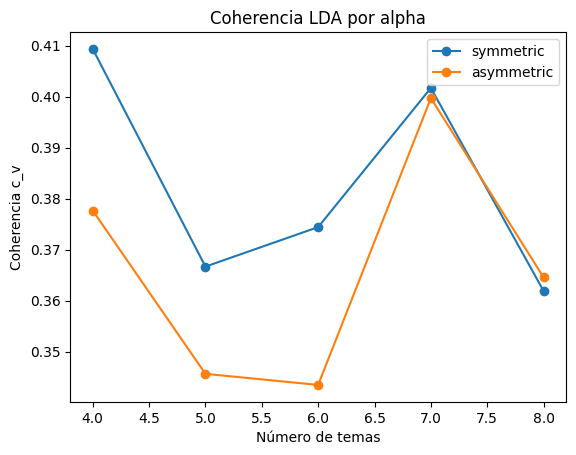

Mejor configuración: {'k': 4, 'alpha': 'symmetric', 'coherence': 0.4093808379736864}


AttributeError: 'LatentDirichletAllocation' object has no attribute 'components_'

In [36]:
import pandas as pd
import re
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# Load spaCy Spanish model for lemmatization
try:
    nlp = spacy.load('es_core_news_sm')
except:
    import spacy.cli
    spacy.cli.download('es_core_news_sm')
    nlp = spacy.load('es_core_news_sm')

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish') + ['si','así','pues','tan','mas','aunque','cuyo','tal','oh','cuanto','ay']

# Load texts
raw = pd.read_csv(OUTPUT_PATH/'corpus_summary'/'csv'/'raw_texts.csv')
docs = raw['text'].fillna('').astype(str).tolist()

# Lemmatize and clean tokens
processed = []
for doc in docs:
    doc_nlp = nlp(re.sub(r'<[^>]+>', ' ', doc))
    tokens = [token.lemma_.lower() for token in doc_nlp 
              if token.is_alpha and token.lemma_.lower() not in stop_words]
    processed.append(tokens)

# Build bigrams/trigrams
bigram = gensim.models.Phrases(processed, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[processed], threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
texts = [trigram_mod[bigram_mod[doc]] for doc in processed]

# Create dictionary and corpus
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=3, no_above=0.3)
corpus = [id2word.doc2bow(text) for text in texts]

# Coherence grid: vary k and alpha
results = []
for k in [4,5,6,7,8]:
    for alpha in ['symmetric','asymmetric']:
        lda = gensim.models.LdaModel(corpus=corpus, id2word=id2word,
                                     num_topics=k, random_state=42,
                                     passes=15, alpha=alpha)
        cm = CoherenceModel(model=lda, texts=texts, dictionary=id2word, coherence='c_v')
        coh = cm.get_coherence()
        results.append((k, alpha, coh))
        print(f"k={k}, alpha={alpha}, coherence={coh:.4f}")

# Plot coherence by k for symmetric vs asymmetric
df_res = pd.DataFrame(results, columns=['k','alpha','coherence'])
for alpha in df_res['alpha'].unique():
    subset = df_res[df_res['alpha']==alpha]
    plt.plot(subset['k'], subset['coherence'], marker='o', label=alpha)
plt.xlabel('Número de temas')
plt.ylabel('Coherencia c_v')
plt.title('Coherencia LDA por alpha')
plt.legend()
plt.savefig(OUTPUT_PATH/'extensions'/'coherence_alpha.png')
plt.show()

# Choose best config
best = df_res.loc[df_res['coherence'].idxmax()]
print("Mejor configuración:", best.to_dict())

best_k, best_alpha = int(best['k']), best['alpha']

# TF-IDF + sklearn LDA with best parameters
vectorizer = TfidfVectorizer(max_df=0.85, min_df=3,
                             stop_words=stop_words, token_pattern=r'(?u)\b\w\w+\b')
X = vectorizer.fit_transform(docs)
    # Map best_alpha to numeric prior
doc_prior = 1.0 / best_k if best_alpha == 'symmetric' else None
doc_prior = 1.0 / best_k if best_alpha == 'symmetric' else None
lda_skl = LatentDirichletAllocation(
    n_components=best_k,
    learning_method='batch',
    random_state=42,
    doc_topic_prior=doc_prior
)

# NMF for comparison
nmf = NMF(n_components=best_k, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Save term-topic matrices
terms = vectorizer.get_feature_names_out()
pd.DataFrame(lda_skl.components_, columns=terms)  .to_csv(OUTPUT_PATH/'extensions'/'lda_topic_terms.csv', index=False)
pd.DataFrame(H, columns=terms)  .to_csv(OUTPUT_PATH/'extensions'/'nmf_topic_terms.csv', index=False)

# Display and save bar charts for LDA
for model, comps, prefix in [('LDA', lda_skl.components_, 'lda'), ('NMF', H, 'nmf')]:
    for i, comp in enumerate(comps):
        top = comp.argsort()[-10:][::-1]
        words = [terms[j] for j in top]
        weights = comp[top]
        plt.figure()
        plt.barh(words[::-1], weights[::-1])
        plt.title(f"{model} Tema {i+1}")
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH/'extensions'/f'{prefix}_topic_{i+1}.png')
        plt.show()